In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import ecephys_analyses as ea
import seaborn as sns
from scipy import stats

In [3]:
def standardize(df):
    df = df.copy()
    levels = df.index.names
    df = df / df.loc['baseline-light-period', 'NREM'] * 100
    df = df.reorder_levels(levels).sort_index()
    return df

In [4]:
rebound_subjects = ["Segundo", "Valentino", "Doppio", "Alessandro", "Allan"] # Eugene is omitted because of missing baseline data.
bandpower_file = 'median-bandpower.csv'
sharp_wave_file = 'median-spw-properties.csv'
standardize_sharp_waves = True

# SWA

In [5]:
pwr = pd.read_csv(ea.package_datapath(bandpower_file))
pwr = pwr.set_index(['condition', 'state', 'region', 'band', 'subject']).sort_index()
pwr = standardize(pwr)

In [6]:
def get_swa_rebound_and_decline(pwr, state):
    rebounds = pwr.loc['first2h-recovery'] - pwr.loc['first2h-recovery-match']
    declines = pwr.loc['early-recovery'] - pwr.loc['late-recovery']

    df = pd.concat(
        [
            rebounds.loc[state, "mpta_wm_ref", "delta"],
            declines.loc[state, "mpta_wm_ref", "delta"],
            rebounds.loc[state, "sr_wm_ref", "delta"],
            declines.loc[state, "sr_wm_ref", "delta"],
        ],
        keys=["cx_rebound", "cx_decline", "hc_rebound", "hc_decline"],
        axis=1,
    ).droplevel(1, axis=1)
    return df

swa_nrem = get_swa_rebound_and_decline(pwr, 'NREM')

In [7]:
print("Does CX-SWA rebound across animals, relative to circadian-matched baseline?")
print(stats.ttest_1samp(swa_nrem['cx_rebound'].loc[rebound_subjects], 0))
print("Does HC-SWA rebound across animals, relative to circadian-matched baseline?")
print(stats.ttest_1samp(swa_nrem['hc_rebound'].loc[rebound_subjects], 0))

Does CX-SWA rebound across animals, relative to circadian-matched baseline?
Ttest_1sampResult(statistic=8.356975506330269, pvalue=0.0011209722874843356)
Does HC-SWA rebound across animals, relative to circadian-matched baseline?
Ttest_1sampResult(statistic=11.956012968072887, pvalue=0.0002804258247693757)


In [8]:
print("Does CX-SWA decline across animals, from the first to the last hour of recovery sleep?")
print(stats.ttest_1samp(swa_nrem['cx_decline'], 0))
print("Does HC-SWA decline across animals, from the first to the last hour of recovery sleep??")
print(stats.ttest_1samp(swa_nrem['hc_decline'], 0))

Does CX-SWA decline across animals, from the first to the last hour of recovery sleep?
Ttest_1sampResult(statistic=5.92885302844769, pvalue=0.0019472394064718706)
Does HC-SWA decline across animals, from the first to the last hour of recovery sleep??
Ttest_1sampResult(statistic=9.437274946448309, pvalue=0.00022552481193794342)


In [9]:
print("Is CX-SWA rebound larger than HC-SWA rebound?")
print(stats.ttest_1samp(swa_nrem['cx_rebound'].loc[rebound_subjects] - swa_nrem['hc_rebound'].loc[rebound_subjects], 0))
print("Is CX-SWA decline larger than HC-SWA decline?")
print(stats.ttest_1samp(swa_nrem['cx_decline'] - swa_nrem['hc_decline'], 0))

Is CX-SWA rebound larger than HC-SWA rebound?
Ttest_1sampResult(statistic=5.375014287625105, pvalue=0.0057878813517291145)
Is CX-SWA decline larger than HC-SWA decline?
Ttest_1sampResult(statistic=3.5840576467822074, pvalue=0.015806938723091784)


In [42]:
cx_swa_increases = pwr.loc['late-deprivation', 'wake', 'mpta_wm_ref', 'delta'] - pwr.loc['early-deprivation', 'wake', 'mpta_wm_ref', 'delta']
hc_swa_increases = pwr.loc['late-deprivation', 'wake', 'sr_wm_ref', 'delta'] - pwr.loc['early-deprivation', 'wake', 'sr_wm_ref', 'delta']
relative_increases = cx_swa_increases - hc_swa_increases
print("Does CX-SWA increase across animals, from the first to the last hour of sleep deprivation?")
assert cx_swa_increases.power.mean() > 0
print(stats.ttest_1samp(cx_swa_increases, 0))
print("Does HC-SWA increase across animals, from the first to the last hour of sleep deprivation?")
assert hc_swa_increases.power.mean() > 0
print(stats.ttest_1samp(hc_swa_increases, 0))
print("Is CX-SWA increase less than HC-SWA increase?")
assert relative_increases.power.mean() < 0
print(stats.ttest_1samp(relative_increases, 0))

Does CX-SWA increase across animals, from the first to the last hour of sleep deprivation?
Ttest_1sampResult(statistic=array([2.00150305]), pvalue=array([0.10174401]))
Does HC-SWA increase across animals, from the first to the last hour of sleep deprivation?
Ttest_1sampResult(statistic=array([5.83024017]), pvalue=array([0.00209835]))
Is CX-SWA increase less than HC-SWA increase?
Ttest_1sampResult(statistic=array([-5.19708741]), pvalue=array([0.00347546]))


In [11]:
print("Note on Pearson p values:")
print("For a given sample with correlation coefficient r, the p-value is the probability that abs(r’) of a random sample x’ and y’ drawn from the population with zero correlation would be greater than or equal to abs(r)")

Note on Pearson p values:
For a given sample with correlation coefficient r, the p-value is the probability that abs(r’) of a random sample x’ and y’ drawn from the population with zero correlation would be greater than or equal to abs(r)


In [12]:
print("Are CX-SWA rebound and CX-SWA decline correlated?")
r, p = stats.pearsonr(swa_nrem['cx_rebound'].loc[rebound_subjects], swa_nrem['cx_decline'].loc[rebound_subjects])
print(f"{p < 0.05}. r-value: {r}, p-value: {p}")
print("Are HC-SWA rebound and HC-SWA decline correlated?")
r, p = stats.pearsonr(swa_nrem['hc_rebound'].loc[rebound_subjects], swa_nrem['hc_decline'].loc[rebound_subjects])
print(f"{p < 0.05}. r-value: {r}, p-value: {p}")

Are CX-SWA rebound and CX-SWA decline correlated?
True. r-value: 0.9542538186248113, p-value: 0.011664426563458325
Are HC-SWA rebound and HC-SWA decline correlated?
False. r-value: 0.7334805944720253, p-value: 0.158399491575959


In [48]:
print("Are CXC-SWA rebound and HC-SWA rebound correlated?")
r, p = stats.pearsonr(swa_nrem['cx_rebound'].loc[rebound_subjects], swa_nrem['hc_rebound'].loc[rebound_subjects])
print(f"{p < 0.05}. r-value: {r}, p-value: {p}")
print("Are CXC-SWA decline and HC-SWA decline correlated?")
r, p = stats.pearsonr(swa_nrem['cx_decline'].loc[rebound_subjects], swa_nrem['hc_decline'].loc[rebound_subjects])
print(f"{p < 0.05}. r-value: {r}, p-value: {p}")
print("Are CX-SWA increease and HC-SWA increase correlated?")
r, p = stats.pearsonr(cx_swa_increases['power'], hc_swa_increases['power'])
print(f"{p < 0.05}. r-value: {r}, p-value: {p}")

Are CXC-SWA rebound and HC-SWA rebound correlated?
False. r-value: -0.7200392692514513, p-value: 0.17015457441500023
Are CXC-SWA decline and HC-SWA decline correlated?
False. r-value: -0.47331136913289107, p-value: 0.4206863169921436
Are CX-SWA increease and HC-SWA increase correlated?
False. r-value: -0.1956759277328605, p-value: 0.7102322329200834


In [47]:
print("Are CX-SWA increase and CX-SWA rebound correlated?")
r, p = stats.pearsonr(cx_swa_increases['power'], swa_nrem['cx_rebound'])
print(f"{p < 0.05}. r-value: {r}, p-value: {p}")
print("Are HC-SWA increase and HC-SWA rebound correlated?")
r, p = stats.pearsonr(hc_swa_increases['power'], swa_nrem['hc_rebound'])
print(f"{p < 0.05}. r-value: {r}, p-value: {p}")

Are CX-SWA increase and CX-SWA rebound correlated?
False. r-value: -0.3250297494354871, p-value: 0.529624152204419
Are HC-SWA increase and HC-SWA rebound correlated?
False. r-value: -0.1308453950467938, p-value: 0.8048519778614377


In [46]:
print("Are CX-SWA increase and CX-SWA decline correlated?")
r, p = stats.pearsonr(cx_swa_increases['power'], swa_nrem['cx_decline'])
print(f"{p < 0.05}. r-value: {r}, p-value: {p}")
print("Are HC-SWA increase and HC-SWA decline correlated?")
r, p = stats.pearsonr(hc_swa_increases['power'], swa_nrem['hc_decline'])
print(f"{p < 0.05}. r-value: {r}, p-value: {p}")

Are CX-SWA increase and CX-SWA decline correlated?
False. r-value: -0.30262935406463864, p-value: 0.5599140518670503
Are HC-SWA increase and HC-SWA decline correlated?
False. r-value: -0.09172327740605474, p-value: 0.8628009251776743


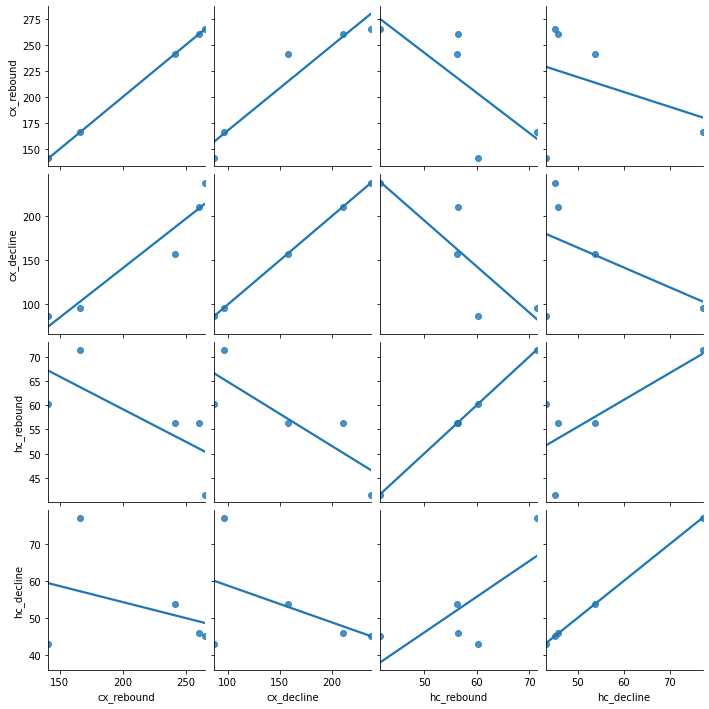

In [14]:
sns.pairplot(swa_nrem.loc[rebound_subjects], kind='reg', diag_kind=None, plot_kws=dict(ci=None))

<AxesSubplot:>

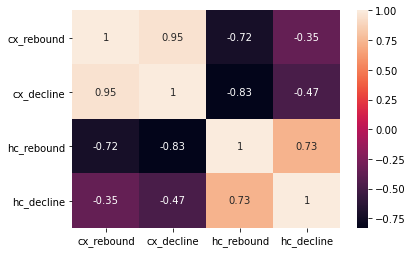

In [15]:
sns.heatmap(swa_nrem.loc[rebound_subjects].corr(method='pearson'), annot=True)

# SPW

In [16]:
spw = pd.read_csv(ea.package_datapath(sharp_wave_file))
spw = spw.pivot(index=['condition', 'state', 'subject'], columns='property', values='value')
spw = standardize(spw) if standardize_sharp_waves else spw

In [17]:
def get_spw_rebound_and_decline(spw, state):
    rebounds = spw.loc['first2h-recovery'] - spw.loc['first2h-recovery-match']
    declines = spw.loc['early-recovery'] - spw.loc['late-recovery']

    df = pd.concat(
        [
            rebounds.loc[state],
            declines.loc[state],
        ],
        keys=["rebound", "decline"],
        axis=1,
    )
    df.columns = ["_".join(a[::-1]) for a in df.columns.to_flat_index()]
    return df

keep_cols = ['rate_rebound', 'sink_amplitude_rebound', 'rate_decline', 'sink_amplitude_decline']
spw_nrem = get_spw_rebound_and_decline(spw, 'NREM')[keep_cols]

In [18]:
print("Does SPW rate rebound across animals, relative to circadian-matched baseline?")
print(stats.ttest_1samp(spw_nrem['rate_rebound'].loc[rebound_subjects], 0))
print("Does SPW sink amplitude rebound across animals, relative to circadian-matched baseline?")
print(stats.ttest_1samp(spw_nrem['sink_amplitude_rebound'].loc[rebound_subjects], 0))

Does SPW rate rebound across animals, relative to circadian-matched baseline?
Ttest_1sampResult(statistic=6.514466181741195, pvalue=0.002866261599447613)
Does SPW sink amplitude rebound across animals, relative to circadian-matched baseline?
Ttest_1sampResult(statistic=4.272286018046378, pvalue=0.012926621552218874)


In [19]:
print("Does SPW rate decline across animals, from the first to the last hour of recovery sleep?")
print(stats.ttest_1samp(spw_nrem['rate_decline'], 0))
print("Does SPW sink amplitude decline across animals, from the first to the last hour of recovery sleep??")
print(stats.ttest_1samp(spw_nrem['sink_amplitude_decline'], 0))

Does SPW rate decline across animals, from the first to the last hour of recovery sleep?
Ttest_1sampResult(statistic=6.397436202050069, pvalue=0.0013829590752415706)
Does SPW sink amplitude decline across animals, from the first to the last hour of recovery sleep??
Ttest_1sampResult(statistic=6.827533497003329, pvalue=0.001028037081562275)


In [20]:
spw_increases = spw.loc['late-deprivation', 'wake'] - spw.loc['early-deprivation', 'wake']
print("Does SPW rate increase across animals, from the first to the last hour of sleep deprivation?")
print(stats.ttest_1samp(spw_increases['rate'], 0))
print("Does SPW sink amplitude increase across animals, from the first to the last hour of sleep deprivation??")
print(stats.ttest_1samp(spw_increases['sink_amplitude'], 0))

Does SPW rate increase across animals, from the first to the last hour of sleep deprivation?
Ttest_1sampResult(statistic=3.5479717236604205, pvalue=0.016422850674982847)
Does SPW sink amplitude increase across animals, from the first to the last hour of sleep deprivation??
Ttest_1sampResult(statistic=2.25689067612338, pvalue=0.07363805690950032)


In [21]:
print("Note on Pearson p values:")
print("For a given sample with correlation coefficient r, the p-value is the probability that abs(r’) of a random sample x’ and y’ drawn from the population with zero correlation would be greater than or equal to abs(r)")

Note on Pearson p values:
For a given sample with correlation coefficient r, the p-value is the probability that abs(r’) of a random sample x’ and y’ drawn from the population with zero correlation would be greater than or equal to abs(r)


In [22]:
print("Are SPW rate rebound and SPW rate decline correlated?")
r, p = stats.pearsonr(spw_nrem['rate_rebound'].loc[rebound_subjects], spw_nrem['rate_decline'].loc[rebound_subjects])
print(f"{p < 0.05}. r-value: {r}, p-value: {p}")
print("Are SPW sink amplitude rebound and SPW sink amplitude decline correlated?")
r, p = stats.pearsonr(spw_nrem['sink_amplitude_rebound'].loc[rebound_subjects], spw_nrem['sink_amplitude_decline'].loc[rebound_subjects])
print(f"{p < 0.05}. r-value: {r}, p-value: {p}")

Are SPW rate rebound and SPW rate decline correlated?
False. r-value: 0.4861816903131884, p-value: 0.406308412190727
Are SPW sink amplitude rebound and SPW sink amplitude decline correlated?
False. r-value: -0.6143798774930493, p-value: 0.27020973262426173


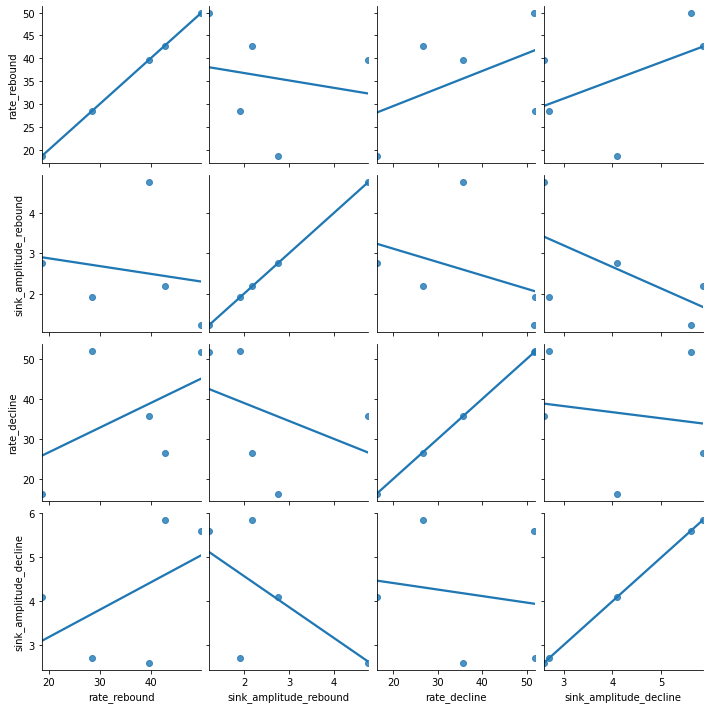

In [23]:
sns.pairplot(spw_nrem.loc[rebound_subjects], kind='reg', diag_kind=None, plot_kws=dict(ci=None))

<AxesSubplot:>

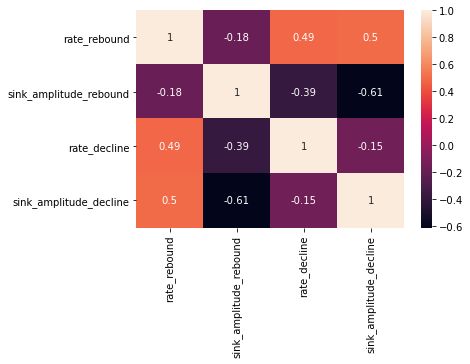

In [24]:
sns.heatmap(spw_nrem.loc[rebound_subjects].corr(method='pearson'), annot=True)

# SWA + SPW

In [25]:
both_nrem = pd.concat([swa_nrem, spw_nrem], axis=1)
x_vars = spw_nrem.columns
y_vars = swa_nrem.columns

In [26]:
print("Note on Pearson p values:")
print("For a given sample with correlation coefficient r, the p-value is the probability that abs(r’) of a random sample x’ and y’ drawn from the population with zero correlation would be greater than or equal to abs(r)")

Note on Pearson p values:
For a given sample with correlation coefficient r, the p-value is the probability that abs(r’) of a random sample x’ and y’ drawn from the population with zero correlation would be greater than or equal to abs(r)


In [27]:
print("Are CX-SWA rebound and SPW rate rebound correlated?")
r, p = stats.pearsonr(swa_nrem['cx_rebound'].loc[rebound_subjects], spw_nrem['rate_rebound'].loc[rebound_subjects])
print(f"{p < 0.05}. r-value: {r}, p-value: {p}")
print("Are CX-SWA rebound and SPW sink amplitude rebound correlated?")
r, p = stats.pearsonr(swa_nrem['cx_rebound'].loc[rebound_subjects], spw_nrem['sink_amplitude_rebound'].loc[rebound_subjects])
print(f"{p < 0.05}. r-value: {r}, p-value: {p}")
print("Are CX-SWA decline and SPW rate decline correlated?")
r, p = stats.pearsonr(swa_nrem['cx_decline'], spw_nrem['rate_decline'])
print(f"{p < 0.05}. r-value: {r}, p-value: {p}")
print("Are CX-SWA decline and SPW sink amplitude decline correlated?")
r, p = stats.pearsonr(swa_nrem['cx_decline'], spw_nrem['sink_amplitude_decline'])
print(f"{p < 0.05}. r-value: {r}, p-value: {p}")

Are CX-SWA rebound and SPW rate rebound correlated?
False. r-value: -0.6526699898333025, p-value: 0.23249528133505057
Are CX-SWA rebound and SPW sink amplitude rebound correlated?
False. r-value: 0.5365744358194352, p-value: 0.3511810922834945
Are CX-SWA decline and SPW rate decline correlated?
False. r-value: 0.21497381511007135, p-value: 0.6825066494612004
Are CX-SWA decline and SPW sink amplitude decline correlated?
True. r-value: -0.9478054977009155, p-value: 0.00401530324954024


In [28]:
print("Are HC-SWA rebound and SPW rate rebound correlated?")
r, p = stats.pearsonr(swa_nrem['hc_rebound'].loc[rebound_subjects], spw_nrem['rate_rebound'].loc[rebound_subjects])
print(f"{p < 0.05}. r-value: {r}, p-value: {p}")
print("Are HC-SWA rebound and SPW sink amplitude rebound correlated?")
r, p = stats.pearsonr(swa_nrem['hc_rebound'].loc[rebound_subjects], spw_nrem['sink_amplitude_rebound'].loc[rebound_subjects])
print(f"{p < 0.05}. r-value: {r}, p-value: {p}")
print("Are HC-SWA decline and SPW rate decline correlated?")
r, p = stats.pearsonr(swa_nrem['hc_decline'], spw_nrem['rate_decline'])
print(f"{p < 0.05}. r-value: {r}, p-value: {p}")
print("Are HC-SWA decline and SPW sink amplitude decline correlated?")
r, p = stats.pearsonr(swa_nrem['hc_decline'], spw_nrem['sink_amplitude_decline'])
print(f"{p < 0.05}. r-value: {r}, p-value: {p}")

Are HC-SWA rebound and SPW rate rebound correlated?
False. r-value: 0.6584411985432017, p-value: 0.22694638644883486
Are HC-SWA rebound and SPW sink amplitude rebound correlated?
False. r-value: -0.21112884371891108, p-value: 0.7331930858450272
Are HC-SWA decline and SPW rate decline correlated?
False. r-value: 0.34909645691610086, p-value: 0.49762721682016536
Are HC-SWA decline and SPW sink amplitude decline correlated?
False. r-value: 0.21038420000909372, p-value: 0.6890796613423555


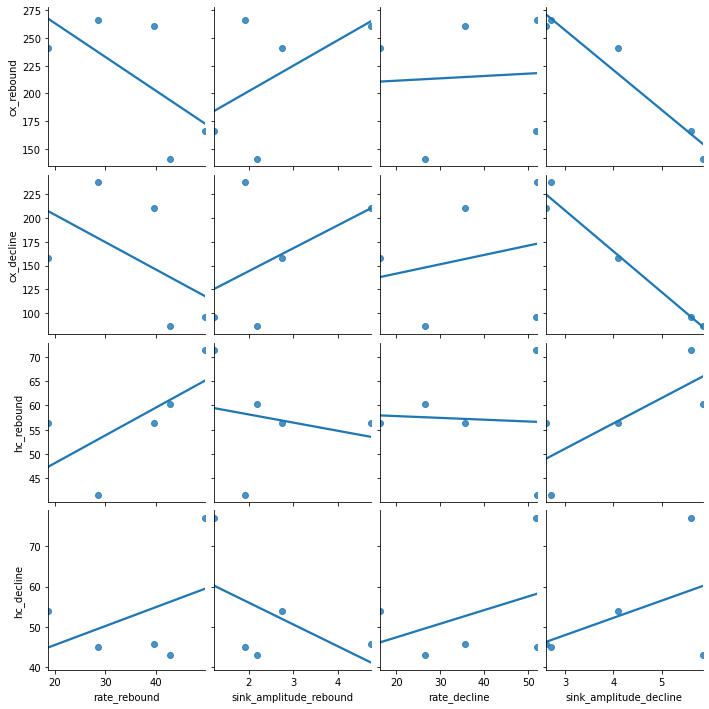

In [29]:
sns.pairplot(both_nrem.loc[rebound_subjects], kind='reg', diag_kind=None, plot_kws=dict(ci=None), x_vars=x_vars, y_vars=y_vars)

<AxesSubplot:>

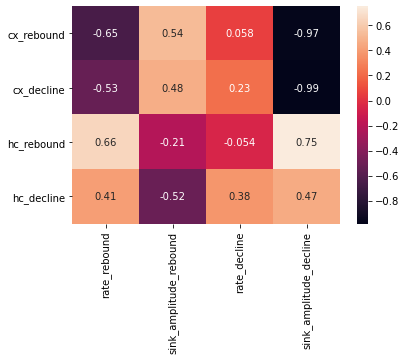

In [30]:
sns.heatmap(both_nrem.loc[rebound_subjects].corr(method='pearson')[x_vars].loc[y_vars], annot=True)